In [12]:
import numpy as np
import pandas as pd
import pymc3 as pm
from os.path import join, isfile
from os import listdir
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import glambox as gb

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Simulate a pretend-to-be-collected dataset.
# In the real world, this dataset is collected from participants, so we do not know
# 1) if GLAM is an adequate model for the data
# 2) data-generating parameters

data_model = gb.GLAM()

parameters = dict(v=dict(mu=0.000075, sd=0.000025, bounds=(0.00002, 0.0002)),
                  gamma=dict(mu=0.1, sd=0.3, bounds=(-1, 1)),
                  s=dict(mu=0.008, sd=0.001, bounds=(0.005, 0.015)),
                  tau=dict(mu=0.8, sd=0.1, bounds=(0.1, 2)))

data_model.simulate_group(kind='hierarchical',
                          n_individuals=50,
                          n_trials=200,
                          n_items=3,
                          parameters=parameters,
                          value_range=(1, 10),
                          seed=1)

data = data_model.data

In [3]:
data.to_csv(join('examples', 'example_3', 'data', 'data.csv'), index=False)

In [4]:
glam = gb.GLAM(data=data)
glam.make_model(kind='individual')
glam.fit(method='MCMC', draws=5000, tune=5000, chains=4)

Generating single subject models for 50 subjects...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Fitting 50 model(s) using MCMC...
  Fitting model 1 of 50...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

  Fitting model 2 of 50...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1569.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1563.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1559.75draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1557.02draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1569.55draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1568.99draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1557.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1559.67draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1564.69draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1551.81draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1549.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1553.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1559.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1559.72draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1543.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1564.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1556.28draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1547.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:26<00:00, 1536.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1550.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 22 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1561.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1547.79draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:26<00:00, 1511.83draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1545.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1542.06draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1546.75draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1552.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1546.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1551.73draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 31 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:25<00:00, 1542.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 32 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1415.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 33 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1406.88draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 34 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1418.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 35 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1396.78draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 36 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1405.89draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 37 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1402.61draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 38 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:31<00:00, 1255.64draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 39 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1412.34draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 40 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1409.52draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 41 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1421.31draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 42 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1418.32draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 43 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1409.96draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 44 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1410.18draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 45 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1414.34draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 46 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1405.41draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 47 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1409.81draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 48 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1396.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 49 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1416.70draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 50 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1420.51draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [5]:
glam.predict(n_repeats=1)
synthetic = glam.prediction

  0%|          | 8/10000 [00:00<02:12, 75.14it/s]

Generating predictions for 10000 trials (1 repeats each)...


100%|██████████| 10000/10000 [02:11<00:00, 73.64it/s]


In [6]:
synthetic.to_csv(join('examples', 'example_3', 'data', 'synthetic.csv'), index=False)

In [7]:
# For this synthetic dataset, we know the generating parameters:
true_parameters = {parameter: glam.estimates[parameter].values
                   for parameter in ['v', 'gamma', 's', 'tau']}

# Save these generating parameters
true_param_df = pd.DataFrame(true_parameters)
true_param_df['subject'] = range(50)
true_param_df.to_csv(join('examples', 'example_3', 'results', 'true_parameters.csv'), index=False)

/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


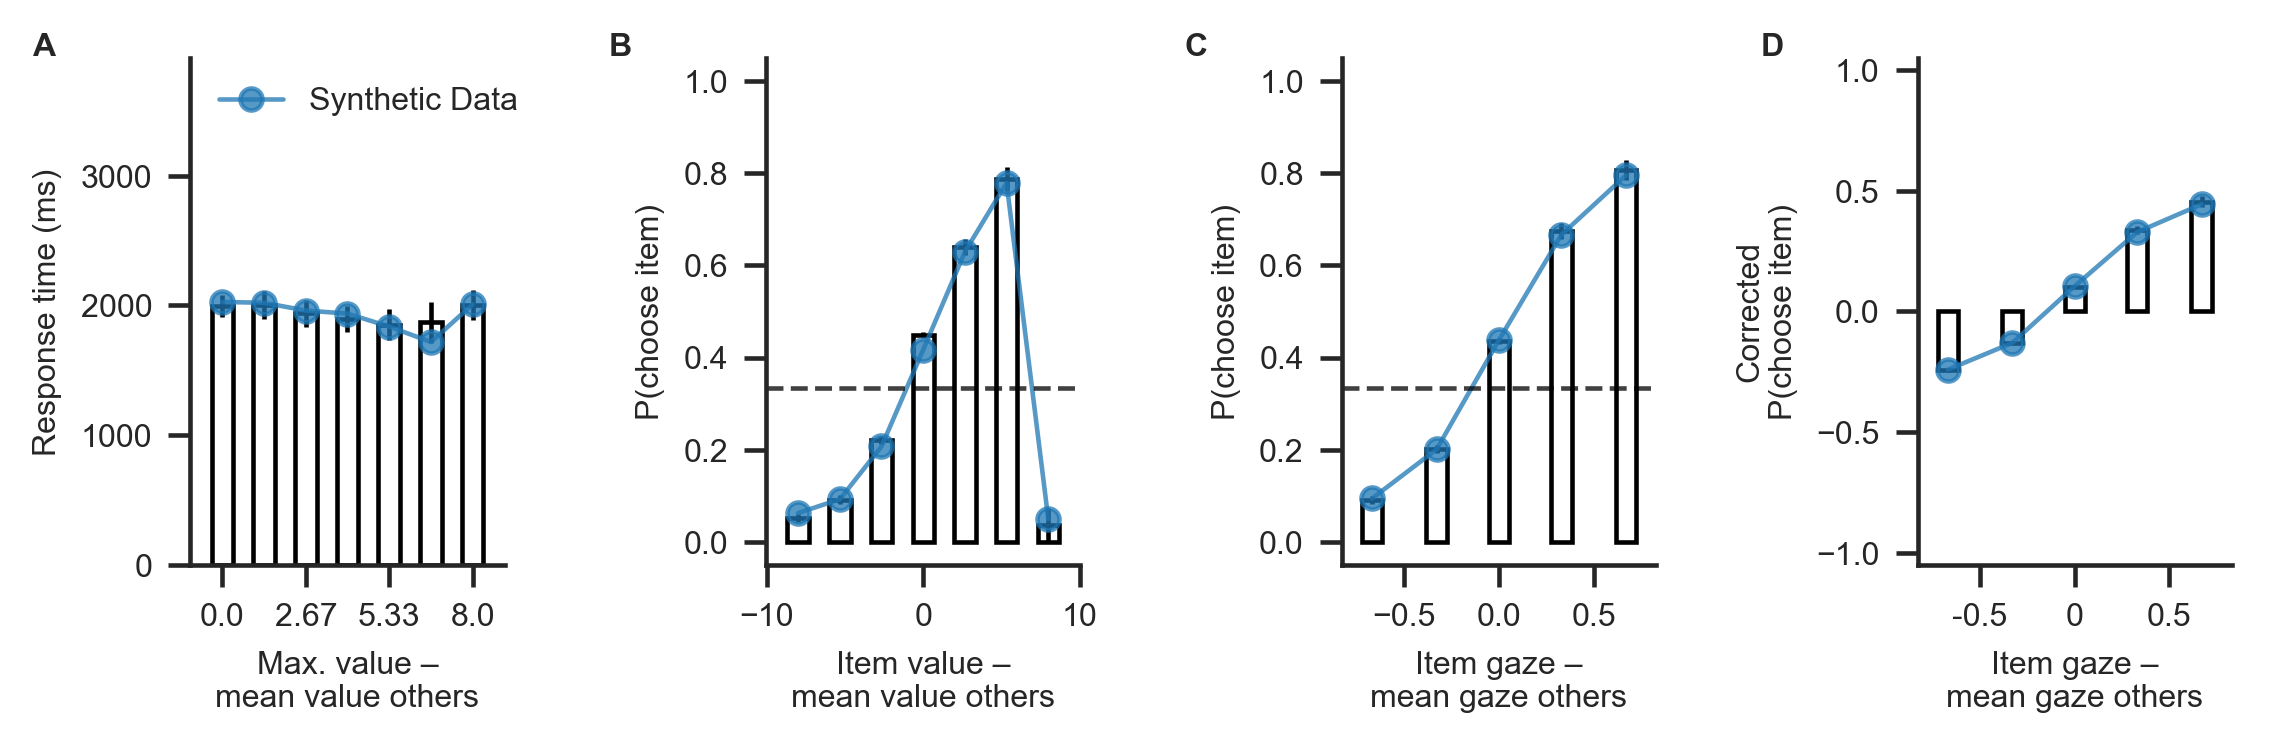

In [19]:
gb.plots.plot_aggregate(data, line_data=[synthetic], line_labels=['Synthetic Data'])
plt.savefig(join('examples', 'example_3', 'figures', 'data-vs-synthetic.png'), dpi=330)

In [9]:
glam_rec = gb.GLAM(data=synthetic)
glam_rec.make_model(kind='individual')
glam_rec.fit(method='MCMC', draws=5000, tune=5000, chains=4)

Generating single subject models for 50 subjects...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Fitting 50 model(s) using MCMC...
  Fitting model 1 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 806.36draws/s] 
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 2 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1417.44draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 3 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1434.40draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 4 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1436.63draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 5 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1407.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 6 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1427.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 7 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1426.09draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 8 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1433.17draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 9 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1423.55draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 10 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1417.86draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 11 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 651.48draws/s] 
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 12 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1442.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 13 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1428.44draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 14 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1429.47draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 15 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1412.65draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 16 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1413.49draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 17 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1423.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 18 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1421.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 19 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1426.57draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 20 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1432.55draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 21 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1416.60draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 22 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1424.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 23 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1432.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 24 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1425.55draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 25 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1432.19draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 26 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1424.07draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 27 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1410.96draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 28 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1423.25draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 29 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1424.29draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 30 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1433.19draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 31 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1421.16draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 32 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1407.76draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 33 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1427.87draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 34 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1425.24draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 35 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1427.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 36 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1429.75draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 37 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1404.54draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 38 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1415.91draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 39 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1413.30draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 40 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1413.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 41 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1430.80draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 42 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1419.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 43 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1396.59draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 44 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1418.77draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 45 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1411.09draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 46 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:27<00:00, 1429.88draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 47 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1420.74draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 48 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1427.27draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 49 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1408.03draws/s]
The number of effective samples is smaller than 10% for some parameters.


  Fitting model 50 of 50...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [s]
>Metropolis: [gamma]
>Metropolis: [v]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:28<00:00, 1401.97draws/s]
The number of effective samples is smaller than 10% for some parameters.


/!\ Automatically setting parameter precision...


In [10]:
glam_rec.estimates.to_csv(join('examples', 'example_3', 'results', 'glam_rec_estimates.csv'), index=False)

In [94]:
def plot_recovery_individual(model, generating_parameters,
                             parameters=['v', 'gamma', 's', 'tau'],
                             xlimits=dict(v=[-0.000025, 0.000025],
                                          gamma=[-0.25, 0.25],
                                          s=[-0.0025, 0.0025],
                                          tau=[-1, 1]),
                             figsize=gb.plots.cm2inch(18, 6),
                             fontsize=7):
    """
    Plot parameter recovery results from individually fitted models.
    
    Args:
        model: Fitted GLAM model of type 'individual'
        generating_parameters (dict): Dictionary of data generating parameters
        parameters (list, optional): List of parameters to include
        figsize (tuple, optional): Figure size
    
    
    """
    parameter_names = {'v': 'v',
                       'gamma': r'$\gamma$',
                       's': r'$\sigma$',
                       'tau': r'$\tau$'}

    n_individuals = len(generating_parameters[parameters[0]])
    n_parameters = len(parameters)

    # Construct long dataframe, 
    # every row is one parameter of one subject
    recovery = []
    for parameter in parameters:
        recovery_p = model.estimates[['subject', parameter, parameter + '_hpd_2.5', parameter + '_hpd_97.5']].copy()
        recovery_p.rename({parameter: 'recovered',
                           parameter + '_hpd_2.5': 'recovered_hpd_lower',
                           parameter + '_hpd_97.5': 'recovered_hpd_upper'},
                          axis=1, inplace=True)
        recovery_p['parameter'] = parameter
        recovery_p['generating'] = generating_parameters[parameter]
        recovery.append(recovery_p)
    recovery = pd.concat(recovery)
    recovery['success'] = ((recovery['generating'] > recovery['recovered_hpd_lower']) &
                           (recovery['generating'] < recovery['recovered_hpd_upper'])).values

    # Plot
    fig = plt.figure(figsize=figsize, dpi=330)
    axs = {}
    for p, parameter in enumerate(parameters):
        axs[(0, p)] = plt.subplot2grid((5, 4), (0, p), rowspan=1)
        axs[(1, p)] = plt.subplot2grid((5, 4), (2, p), rowspan=4, sharex=axs[(0, p)])

    for p, parameter in enumerate(parameters):
        parameter_df = recovery.loc[recovery['parameter'] == parameter]
    
        # Histogram of differences
        delta = (parameter_df['recovered'] - parameter_df['generating']).values
        axs[(0, p)].hist(delta,
                         color='black', alpha=0.3,
                         bins=np.linspace(*xlimits[parameter], 21))
        axs[(0, p)].axvline(0,
                            color='black', linewidth=0.5, alpha=0.7)
        axs[(0, p)].set_ylabel('Freq.',
                               fontsize=fontsize)
        for label in axs[(0, p)].get_xticklabels():
            label.set_visible(False)
    
        # Individual HPDs around true value
        ## Success Color coding
        color = np.array(['red', 'green'])[parameter_df['success'].values.astype(int)]
        
        ## Vertical, indicating zero difference
        axs[(1, p)].axvline(0, color='black', zorder=-1, linewidth=0.5, alpha=0.7)
        ## Difference posterior mean - generating
        axs[(1, p)].scatter(x=delta,
                   y=range(n_individuals),
                   color=color,
                   s=4,
                   marker='o', facecolor='white',
                   zorder=2)
        ## HPD        
        axs[(1, p)].hlines(y=range(n_individuals),
                           xmin=parameter_df['recovered_hpd_lower'].values - parameter_df['generating'].values,
                           xmax=parameter_df['recovered_hpd_upper'].values - parameter_df['generating'].values,
                           linewidth=0.5,
                           zorder=1,
                           color=color)

        ## Labels
        axs[(1, p)].set_xlabel(r'$\Delta$' + parameter_names[parameter], 
                      fontsize=fontsize)
        axs[(1, p)].set_ylabel('Participant',
                      fontsize=fontsize)
                
        ## Limits
        axs[(1, p)].set_xlim(*xlimits[parameter])

        ## Panel Labels
        from string import ascii_uppercase
        for label, ax in zip(list(ascii_uppercase),
                             [axs[i, p]
                              for i in [0, 1]
                              for p in range(len(parameters))]):
            ax.tick_params(axis='both', which='major', labelsize=fontsize)
            ax.text(-0.3, 1.05, label, transform=ax.transAxes,
                    fontsize=fontsize, fontweight='bold', va='top')
        sns.despine()
        fig.tight_layout(h_pad=-1)
        
        for ax in [axs[(1, p)]
                      for p in range(len(parameters))]:
            ax.set_yticks([])

    return fig, axs

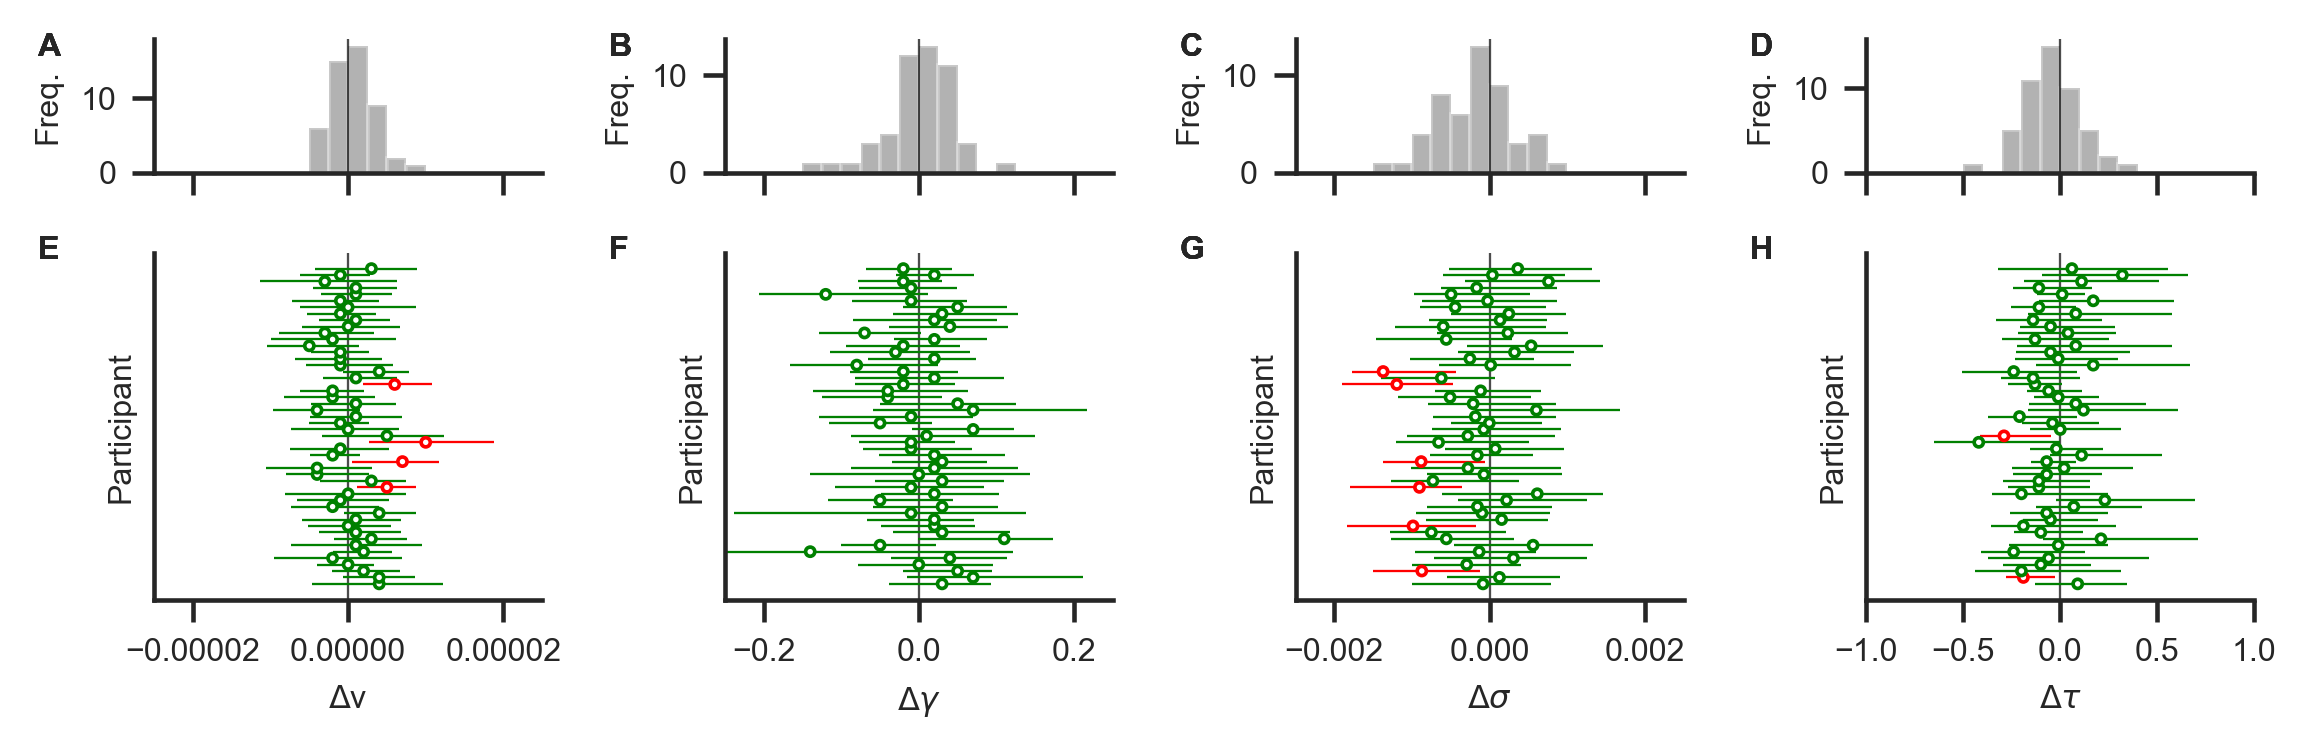

In [95]:
fig, axs = plot_recovery_individual(glam_rec, true_parameters);
plt.savefig(join('examples', 'example_3', 'figures', 'deltaGenRec.png'), dpi=330)